In [1]:
from IPython.display import display, HTML
import cv2
import sqlite3
from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA

from visualize_model import Model
from database import blob_to_array, pair_id_to_image_ids
from plotly import graph_objects as go
from utils import triangulate, euclidean2homogeneous, homogeneous2euclidean

import collections
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 2. Analyze reconstructions using python
## 2.1. Run the notebook, using the Gerrard Hall reconstruction (0.5)
#### <span style='color:Green'> - Add the path to your reconstruction. Answer the questions at the end  </span>

In [2]:
# Add your path
# Get the path of the current notebook
import os
current_path = os.getcwd()
# Cut the current path until the folder "M4_Project"
current_path = current_path[:current_path.find("M4_Project")]
current_path

'c:\\Users\\Johnny\\Documents\\Projects\\'

In [3]:

reconstruction_path = current_path + "ReconstructionAnna/gerrard-hall/dense/0/sparse"
database_path = current_path + "ReconstructionAnna/gerrard-hall/database.db"
print(reconstruction_path)
print(database_path)

c:\Users\Johnny\Documents\Projects\ReconstructionAnna/gerrard-hall/dense/0/sparse
c:\Users\Johnny\Documents\Projects\ReconstructionAnna/gerrard-hall/database.db


#### Load an existing reconstruction and print its contents

In [4]:
model = Model()
model.read_model(reconstruction_path, ext='.bin') # Should also work with .txt


In [5]:
images = model.images
cameras = model.cameras
points3D = model.points3D

In [6]:
print(f"Loaded {len(images)} images. This is the information available for one of them:")
print(images[1])
print(f"\nLoaded {len(cameras)} cameras. This is the information available for one of them:")
print(cameras[1])
print(f"\nLoaded {len(points3D)} 3D points. This is the information available for one of them:")
print(points3D[1])

Loaded 100 images. This is the information available for one of them:
Image(id=1, qvec=array([-0.13307998,  0.02001329,  0.97092963, -0.19795161]), tvec=array([0.95233141, 1.10338676, 4.49256751]), camera_id=1, name='IMG_2331.JPG', xys=array([[ 310.81109577,   -7.92896802],
       [ 310.81109577,   -7.92896802],
       [ 472.94921897,   -1.56668219],
       ...,
       [1478.34052748,  235.0744886 ],
       [ 505.53493695,  314.10142543],
       [ 263.00945079,  803.00888826]]), point3D_ids=array([-1, -1, -1, ..., -1, -1, -1]))

Loaded 1 cameras. This is the information available for one of them:
Camera(id=1, model='PINHOLE', width=1600, height=1041, params=array([1046.77272789, 1047.24283438,  800.        ,  520.5       ]))

Loaded 58543 3D points. This is the information available for one of them:
Point3D(id=1, xyz=array([ 0.63371187, -1.34452886, -1.57616927]), rgb=array([108, 106, 111]), error=array(0.87029534), image_ids=array([58, 60, 59, 56, 57]), point2D_idxs=array([ 388,   28,

#### Load the database

In [7]:
db = sqlite3.connect(database_path)

In [8]:
# keypoints = dict(
#         (image_id, blob_to_array(data, np.float32, (-1, 2)))
#         for image_id, data in db.execute(
#             "SELECT image_id, data FROM keypoints"))

keypoints = dict(
        (image_id, blob_to_array(data, np.float32, (-1, cols)))
        for image_id, cols, data in db.execute(
            "SELECT image_id, cols, data FROM keypoints"))

In [9]:
print(f"Loaded keypoints from {len(keypoints)} images. These are the {len(keypoints[1])} keypoints for one of them:")
print(keypoints[1])

Loaded keypoints from 100 images. These are the 8621 keypoints for one of them:
[[ 1.0773304e+03  3.3447936e+00  3.6073356e+00  4.5422158e+00
  -4.5393767e+00  3.6095915e+00]
 [ 1.0773304e+03  3.3447936e+00 -2.6590879e+00  5.1557035e+00
  -5.1524811e+00 -2.6607509e+00]
 [ 1.6401766e+03  8.6563883e+00  9.9802482e-01 -5.2196026e+00
   5.2163401e+00  9.9864894e-01]
 ...
 [ 5.2041206e+03  8.6423633e+02 -1.5348967e+02 -2.4854147e+02
   2.4838614e+02 -1.5358566e+02]
 [ 1.7390922e+03  1.1231097e+03  3.1724677e+02 -1.6370161e+02
   1.6359929e+02  3.1744516e+02]
 [ 8.8910846e+02  2.8810691e+03  2.4314832e+02 -3.0269171e+02
   3.0250253e+02  2.4330038e+02]]


In [10]:
# Aqui no s'hauria d'arreglar el cols ??
matches = dict()
count_no_data = 0
for pair_id, data in db.execute("SELECT pair_id, data FROM matches"):
    if data is None:
        count_no_data += 1
    else:
        matches[pair_id_to_image_ids(pair_id)] = blob_to_array(data, np.uint32, (-1, 2))
print(f"Loaded {len(matches)} matches. {count_no_data}/{len(matches)+count_no_data} matches contained no data")


Loaded 3174 matches. 1776/4950 matches contained no data


In [11]:
print("These are the matches between two images:")
print(matches[1,3])

These are the matches between two images:
[[ 212  125]
 [ 213  126]
 [ 363 3928]
 ...
 [8607 9089]
 [8609 9091]
 [8620 9108]]


#### Visualize the point cloud and cameras

In [12]:
# model.create_window()
# model.add_points()
# model.add_cameras(scale=0.25)
# model.show()

#### <span style='color:Green'>  How many keypoints there are in total? </span> 

In [13]:
sum=0
for i in range(len(keypoints)):
    sum += len(keypoints[i+1])

print(f"Total number of keypoints: {sum}")

Total number of keypoints: 1068663


#### <span style='color:Green'>  How many 3D points originated from a keypoint in the first image? </span>


In [14]:

img_idx = 1

print(f"Check len(images): {len(images)}")
print(f"Check len(keypoints): {len(keypoints)}")

print(f"Check num keypoints first image: {len(keypoints[img_idx])}")
print(f"Check num xys points first image: {len(images[img_idx].xys)}")

print(f"Check first keypoints first image: {keypoints[img_idx][0]}")
print(f"Check first xys points first image: {images[img_idx].xys[0]}")

# Print the kp of the first image in a .txt file
with open("keypoints.txt", "w") as f:
    for i in range(len(keypoints[img_idx])):
        f.write(f"{keypoints[img_idx][i][0]} {keypoints[img_idx][i][1]}\n")

# Print the xys of the first image in a .txt file
with open("xys.txt", "w") as f:
    for i in range(len(images[img_idx].xys)):
        f.write(f"{images[img_idx].xys[i][0]} {images[img_idx].xys[i][1]}\n")

# Find how many 3D points are associated to the first image
points2D_idx = []
for i in range(len(points3D)):
    try:
        if np.any(points3D[i+1].image_ids == img_idx):
            point_idx = np.where(points3D[i+1].image_ids == img_idx)[0].item()
            points2D_idx.append(points3D[i+1].point2D_idxs[point_idx])
    except:
        continue

print(f"\nTotal 3D points: {len(points3D)}")
print(f"Number of 3D points originated from the keypoints of the first image: {len(points2D_idx)}")

sorted_points2D_idx = sorted(points2D_idx)
sorted_points2D_idx

# Find the repeated keypoints --> it means that they are associated to more than one 3D point
print([item for item, count in collections.Counter(sorted_points2D_idx).items() if count > 1]) # LA LLISTA SURT BUIDA, AIXO VOL DIR QUE PER CADA KP GENERA UN I NOMÉS UN PUNT 3D


# print(points3D[44228].image_ids)
# print(points3D[45082].image_ids)
# print(points3D[45084].image_ids)
# print(np.where(points3D[44228].image_ids == img_idx)[0].item())
# print(np.where(points3D[45082].image_ids == img_idx)[0].item())
# print(np.where(points3D[45084].image_ids == img_idx)[0].item())
# print(points3D[44228].point2D_idxs)
# print(points3D[45082].point2D_idxs)
# print(points3D[45084].point2D_idxs)
# print(points3D[44228].point2D_idxs[np.where(points3D[44228].image_ids == img_idx)[0].item()])
# print(points3D[45082].point2D_idxs[np.where(points3D[45082].image_ids == img_idx)[0].item()])
# print(points3D[45084].point2D_idxs[np.where(points3D[45084].image_ids == img_idx)[0].item()])



Check len(images): 100
Check len(keypoints): 100
Check num keypoints first image: 8621
Check num xys points first image: 8621
Check first keypoints first image: [1077.3304       3.3447936    3.6073356    4.542216    -4.5393767
    3.6095915]
Check first xys points first image: [310.81109577  -7.92896802]

Total 3D points: 58543
Number of 3D points originated from the keypoints of the first image: 1719
[]


## 2.2 Plot the 3D points coloured according to the number of images and error. (0.5)

#### <span style='color:Green'> - Plot the 3D points coloured according to the **number of images** from which it originated. </span> Can you extract any conclusions from the visualization? 

(50463, 3)
(50463,)


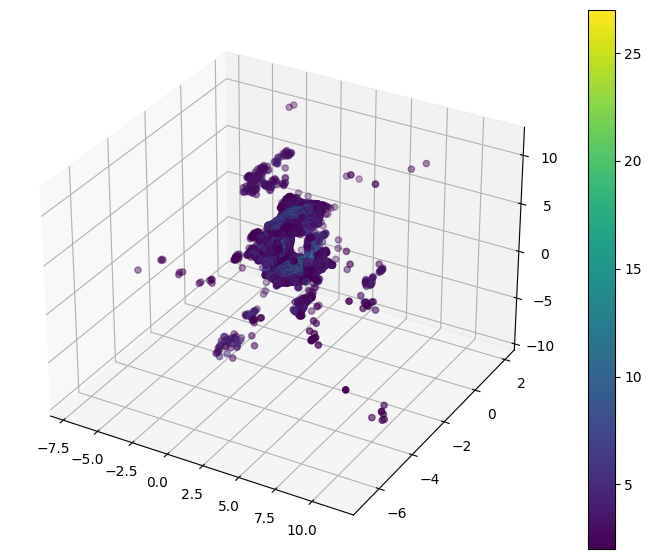

In [15]:
### TO DO 2.2
def draw_points(points, color, ax=None, colorbar=True, only_one_point=False, **plot_kwargs):
    # Creating figure
    
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection="3d")
    # Creating 3D scatter plot with num_images as intensity of color
    # alpha = num_images / np.max(num_images)
    # ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], c=color, alpha=alpha, **plot_kwargs)
    if only_one_point==False:
        p = ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], c=color, **plot_kwargs)
    else:
        p = ax.scatter3D(points[0], points[1], points[2], c=color, **plot_kwargs)
    if colorbar:
        fig.colorbar(p)

points3D_xyz = []
num_images = []
error = []
rgb = []
for i in range(len(points3D)): 
    try:
        points3D_xyz.append(points3D[i+1].xyz)
        num_images.append(len(points3D[i+1].image_ids))
        error.append(points3D[i+1].error)
        rgb.append(points3D[i+1].rgb)
    except:
        continue

points3D_xyz = np.array(points3D_xyz)
num_images = np.array(num_images)
error = np.array(error)
rgb = np.array(rgb)/255

print(points3D_xyz.shape)
print(num_images.shape)

draw_points(points3D_xyz, color=num_images, ax=None)



#### <span style='color:Green'> - Plot the 3D points coloured according to the **error**. </span> - What is this parameter? Can you extract any conclusions from the visualization?

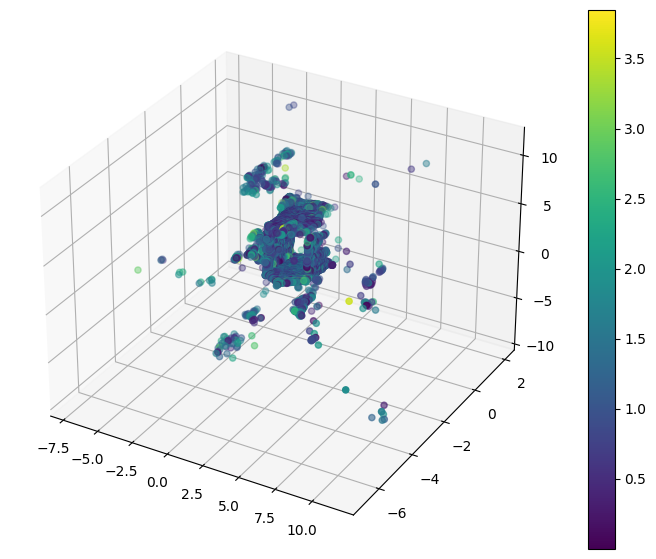

In [16]:
### TO DO 2.2
draw_points(points3D_xyz, color=error, ax=None)

## 2.3 Plot the 3D points that correspond to a keypoint in the first image. Also plot the image with the keypoints (1.0)


[ 0.52114873 -0.94238241  3.16694509]
[0.99607843 1.         0.99607843]


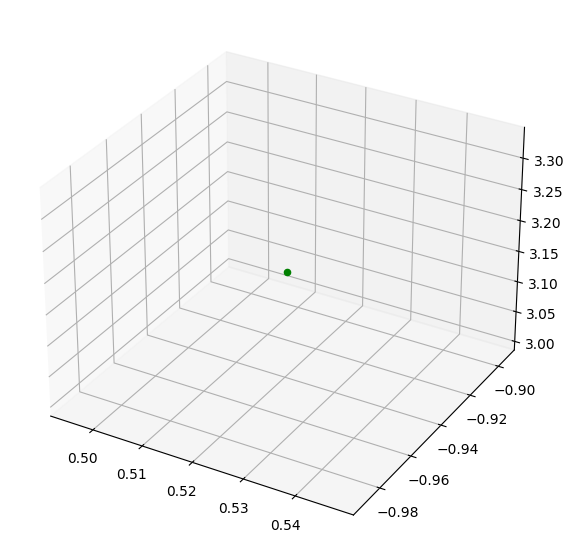

In [17]:
### TO DO 2.3
# We will use one random kp from the first image that we know that it is associated to a 3D point
kp_idx = sorted_points2D_idx[0]
img_idx = 1

point_idx = images[img_idx].point3D_ids[kp_idx]
print(points3D[point_idx].xyz)
print(points3D[point_idx].rgb/255)

# draw_points(points3D[point_idx].xyz, [points3D[point_idx].rgb/255], ax=None, colorbar=False, only_one_point=True)
draw_points(points3D[point_idx].xyz, "green", ax=None, colorbar=False, only_one_point=True)

c:\Users\Johnny\Documents\Projects\ReconstructionAnna/gerrard-hall/images/IMG_2331.JPG


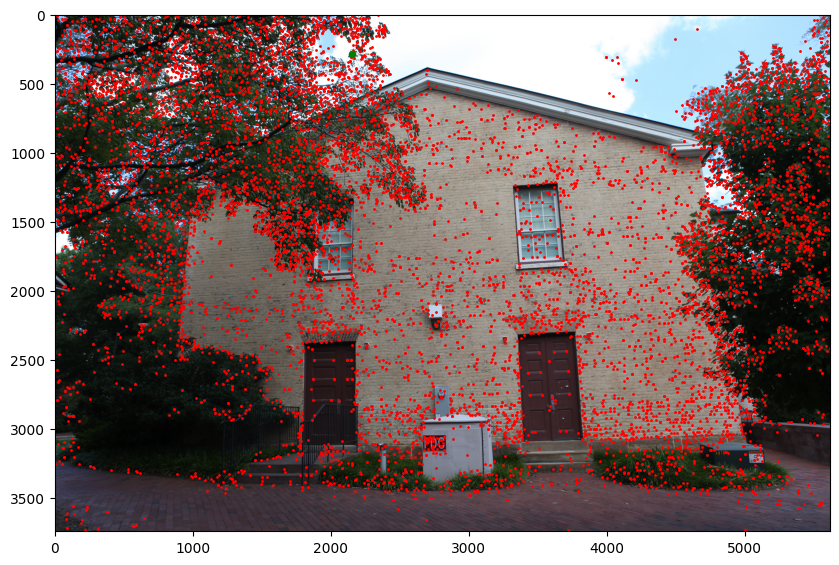

In [18]:

image_name = images[1].name
image_path = database_path[:database_path.rfind('/')] + "/images/" + image_name
print(image_path)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Plot the image with the keypoints 
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.scatter(keypoints[1][:, 0], keypoints[1][:, 1], s=1, marker="o", color="r")
plt.scatter(keypoints[1][kp_idx,0], keypoints[1][kp_idx,1], s=20, marker="o", color="g")
plt.show()


c:\Users\Johnny\Documents\Projects\ReconstructionAnna/gerrard-hall/images/IMG_2331.JPG


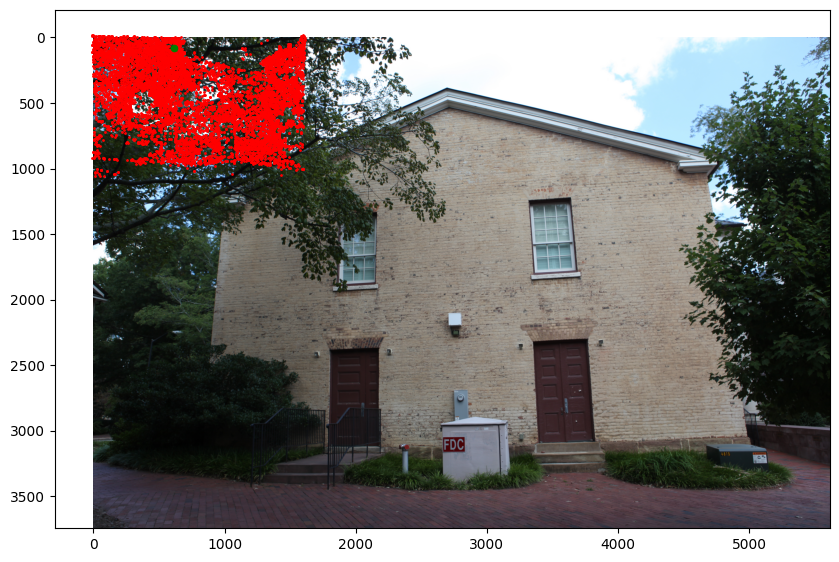

In [19]:
image_name = images[1].name
image_path = database_path[:database_path.rfind('/')] + "/images/" + image_name
print(image_path)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Plot the image with the keypoints 
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.scatter(images[1].xys[:, 0], images[1].xys[:, 1], s=1, marker="o", color="r")
plt.scatter(images[1].xys[kp_idx,0], images[1].xys[kp_idx,1], s=20, marker="o", color="g")
plt.show()

## 2.4 Create a visualization for the number of matches between all images. (1.0)
For example: https://seaborn.pydata.org/generated/seaborn.heatmap.html

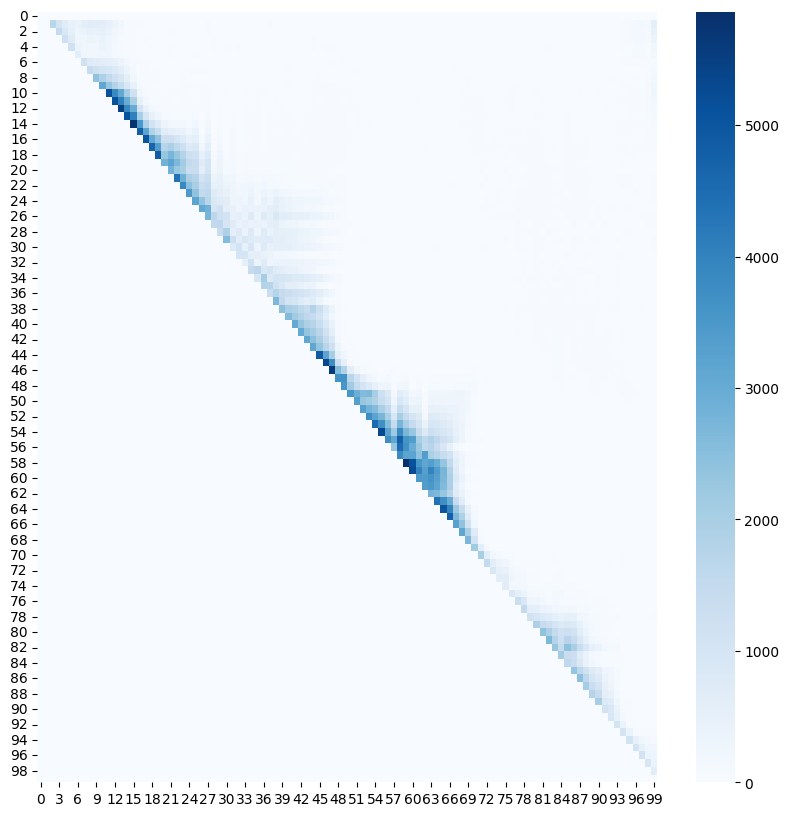

In [20]:
### TO DO 2.4
# Create a matrix that counts the number of matches between each pair of images
matches_matrix = np.zeros((len(images), len(images)))
for i in range(len(images)):
    for j in range(len(images)):
        try:
            matches_matrix[i+1,j+1] = len(matches[i+1,j+1])
        except:
            continue

# Plot the matrix using sns.heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(matches_matrix, cmap="Blues")
plt.show()

## 2.5 Visualize the keypoints and matches between the two images used in lab 4 using Colmap, how it compares to the results from lab 4? (1.0)
#### <span style='color:Green'> You can use the GUI to get the keypoints and matches and then visualize it here, following the same style as in lab 4 to get comparable results. </span>

c:\Users\Johnny\Documents\Projects\ReconstructionAnna/castle-2images/dense/0/sparse
c:\Users\Johnny\Documents\Projects\ReconstructionAnna/castle-2images/database.db
Loaded 2 images. This is the information available for one of them:
Image(id=1, qvec=array([1., 0., 0., 0.]), tvec=array([ 4.73553074, -0.28060601, -1.57987622]), camera_id=1, name='0001_s.png', xys=array([[111.64410723,   7.34024814],
       [123.85298535,   7.63764723],
       [ 14.76868345,   9.28049309],
       ...,
       [589.25275518, 331.5703982 ],
       [354.01194555, 390.67013189],
       [697.51751577, 460.43913672]]), point3D_ids=array([-1, -1, -1, ..., -1, -1, -1]))

Loaded 2 cameras
Camera(id=1, model='PINHOLE', width=911, height=606, params=array([993.12470842, 993.12470842, 455.5       , 303.        ]))
Camera(id=2, model='PINHOLE', width=910, height=605, params=array([1024.81416879, 1024.81416879,  455.        ,  302.5       ]))

Loaded 1629 3D points. This is the information available for one of them:
Poi

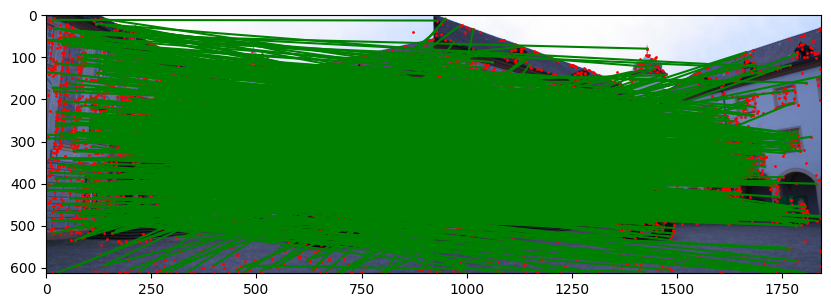

In [21]:
### TO DO 2.5
# castle-2images
reconstruction_path_2 = current_path + "ReconstructionAnna/castle-2images/dense/0/sparse"
database_path_2 = current_path + "ReconstructionAnna/castle-2images/database.db"
print(reconstruction_path_2)
print(database_path_2)

model_2 = Model()
model_2.read_model(reconstruction_path_2, ext='.bin') # Should also work with .txt
images_2 = model_2.images
cameras_2 = model_2.cameras
points3D_2 = model_2.points3D

print(f"Loaded {len(images_2)} images. This is the information available for one of them:")
print(images_2[1])
print(f"\nLoaded {len(cameras_2)} cameras")
print(cameras_2[1])
print(cameras_2[2])
print(f"\nLoaded {len(points3D_2)} 3D points. This is the information available for one of them:")
print(points3D_2[1])

db_2 = sqlite3.connect(database_path_2)

keypoints_2 = dict(
        (image_id, blob_to_array(data, np.float32, (-1, cols)))
        for image_id, cols, data in db_2.execute(
            "SELECT image_id, cols, data FROM keypoints"))

matches_2 = dict()
count_no_data = 0
for pair_id, data in db.execute("SELECT pair_id, data FROM matches"):
    if data is None:
        count_no_data += 1
    else:
        matches_2[pair_id_to_image_ids(pair_id)] = blob_to_array(data, np.uint32, (-1, 2))
print(f"Loaded {len(matches)} matches. {count_no_data}/{len(matches)+count_no_data} matches contained no data")


# Plot matches between two images images_2[1].name and images_2[2].name
image_1 = cv2.imread(database_path_2[:database_path_2.rfind('/')] + "/images/" + images_2[1].name)
image_2 = cv2.imread(database_path_2[:database_path_2.rfind('/')] + "/images/" + images_2[2].name)
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

# Plot image_1 and image_2 matches
plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((image_1, image_2)))
plt.scatter(keypoints_2[1][:, 0], keypoints_2[1][:, 1], s=1, marker="o", color="r")
plt.scatter(keypoints_2[2][:, 0] + image_1.shape[1], keypoints_2[2][:, 1], s=1, marker="o", color="r")
for match in matches_2[(1,2)]:
    try:
        plt.plot([keypoints_2[1][match[0], 0], keypoints_2[2][match[1], 0] + image_1.shape[1]], [keypoints_2[1][match[0], 1], keypoints_2[2][match[1], 1]], color="g")
    except:
        continue
plt.show()




## 2.6 Triangulate and visualize the 3D points from the keypoints extracted using Colmap on the two images used in lab 4, how it compares to the results from lab 4? (1.0) 
#### <span style='color:Green'> - Use the triangulation from lab 4 to the get the 3D points and visualize them following the same style. </span>

In [27]:
K_1 = [[cameras_2[1].params[0], 0, cameras_2[1].params[2]],
    [0, cameras_2[1].params[1], cameras_2[1].params[3]],
    [0, 0, 1]]
K_1 = np.array(K_1)

K_2 = [[cameras_2[2].params[0], 0, cameras_2[2].params[2]],
    [0, cameras_2[2].params[1], cameras_2[2].params[3]],
    [0, 0, 1]]
K_2 = np.array(K_2)

# Compute the essential matrix using the keypoints and matches
T_1 = images_2[1].tvec
R_1 = images_2[1].qvec2rotmat()

T_2 = images_2[2].tvec
R_2 = images_2[2].qvec2rotmat()





In [22]:
### TO DO 2.6
P1 = np.zeros((3,4))
P1[0,0]=P1[1,1]=P1[2,2]=1                            # Cam1 Canonical Camera Matrix

angle = 15
theta = np.radians(angle)
c = np.cos(theta)
s = np.sin(theta)
R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])     # Cam2 Rotation_z(theta[deg])
t = np.array([[1.1, .1, .2]])                         # Cam2 Translation(x[m], y[m], z[m]) 
P2 = np.concatenate((R, t.T), axis=1)

n_points = 20                                        # Number of data samples (points) (x,y,z)
X_eucl = np.random.uniform(0, 1, (3,n_points))       # Random points in 3D space on world reference frame
X_eucl[2,:] += 3                                     # Make points fit into the camera frame 
X = euclidean2homogeneous(X_eucl)                    # 

# Obtain the camera coordinates (rays) from each point.
x_proj1 = P1 @ X                                     # Project to Cam1 image coordinates (x,y,z)->[x_c1:y_c1:z_c1]
x_proj2 = P2 @ X                                     # Project to Cam2 image coordinates (x,y,z)->[x_c2:y_c2:z_c2]

# Estimate the 3D points (you need to create this function)
X_trian = triangulate(x_proj1, x_proj2, P1, P2, ((2,2)))
assert X_trian.shape == (4, n_points)

# Evaluation: compute the reprojection error
X_eucl_pred = homogeneous2euclidean(X_trian)
X_eucl = homogeneous2euclidean(X)
errors = np.linalg.norm(X_eucl - X_eucl_pred, axis=0)
avg_error = np.mean(errors)
print(f"Average triangulation error: {avg_error:.2e}[m]")
assert avg_error < 1e-8, "Something might be wrong here"

Average triangulation error: 1.19e-15[m]


## 2.7 Visualize the sparse reconstruction using the 2 images from lab 4, and the complete CASTLE dataset. Comment on the differences between techniques and number of images used. (1.0)
#### <span style='color:Green'> - Use the reconstruction from Colmap to the get the 3D points and visualize them following the same style, using two images and the complete dataset. </span>

In [23]:
### TO DO 2.7